# 0. Intro
This file contains the process of detecting lines, to estimating the angle of the camera based on the detected lines.

## 1. Setting up the environment
Importing necessary libraries

In [139]:
import cv2
import numpy as np
import random
import os
import math
import matplotlib.pyplot as plt

### 1.1 Initialize varibles, and loading images

In [140]:
imgsPath='imgs'
taken_pos=-4
thresh=150
imgs=[]
edges_imgs=[]

*Note: `taken_pos=3` will be used for determining position of the image taken inside of `imgsPath`, for testing purposes.*

#### Loading, resize, and transforming the images.
- Loading: The images are taken from imgsPath
- Resize: The given size will be equal to 40% *(can be changed to larger size by adjusting the number 0.4 at `arrayTemp` variable)* of that image.
- Transform: First, it will be downscaled to gray color chanel. Secondly, bluring process take place *(this may cause the lines to be harder to recognize, however, noises and unwanted objects such as dust or smaller objects can be eliminated; If resulting in inaccurate results, this process can be reduced)*. Subsequently, the outline will be extracted with Canny.

In [141]:

#Reading and Adding images
for path in os.listdir(imgsPath):
    print(f'Reading from {os.path.join(imgsPath,path)}')

    img=cv2.imread(os.path.join(imgsPath,path))
    
    arrayTemp=np.array(img.shape[:-1])*0.4

    W,H=int(arrayTemp[0]),int(arrayTemp[1])

    img=cv2.resize(img,(H,W))

    # 1. Convert to gray & denoise
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # 2. Outline extraction with Canny
    edges = cv2.Canny(blur, 10, 200)

    imgs.append(img)
    edges_imgs.append(edges)


Reading from imgs\1.jpg
Reading from imgs\2.jpg
Reading from imgs\3.jpg
Reading from imgs\4.jpg
Reading from imgs\5.jpg
Reading from imgs\6.jpg
Reading from imgs\7.jpg


### 1.2 Create necessary functions

In [142]:
def convertCoordinates(rho,theta):
    scale=3000 # Scale number used for scale up the lines (Make it longer)

    x0=rho*np.cos(theta)
    y0=rho*np.sin(theta)

    a=np.cos(theta)
    b=np.sin(theta)

    
    x1=int(x0+scale*(-b))
    y1=int(y0+scale*(a))
    x2=int(x0-scale*(-b))
    y2=int(y0-scale*(a))

    return (x1,y1),(x2,y2)

def convertDegree(thetas):
    alpha=thetas - np.pi/2
    return np.abs(np.degrees(alpha))

# Draw function and log function (For detailing)
def draw(img,lines):
    colors=[(random.randint(10,255),random.randint(20,255),random.randint(30,255)) for i in range(len(lines))]
    img_c=img.copy()

    for i in range(len(lines)):
        rho=lines[i][0][0]
        theta=lines[i][0][1]

        (x1,y1),(x2,y2)=convertCoordinates(rho,theta)

        print(f"p: {rho}; theta: {theta}")
        cv2.line(img_c,(x1,y1),(x2,y2),colors[i],5)
        plt.imshow(img_c)
        plt.show()

Showing the last inputted image properties (bluring, and Canny detect)

***Blur***

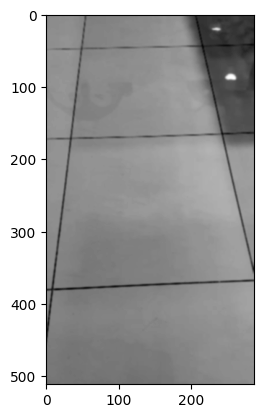

In [143]:
import matplotlib.pyplot as plt
plt.gray()
plt.imshow(blur)
plt.show()

***Canny (Edges)***

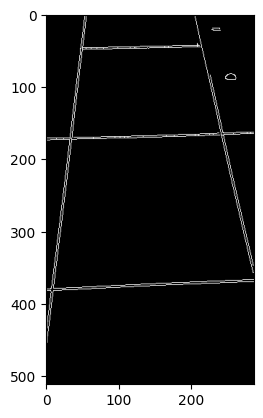

In [144]:
plt.imshow(edges)
plt.show()

### 2.0 Line detection
**Hough Transform** in OpenCV: feed an edge map *(usually from Canny)* into `cv2.HoughLines`, `cv2.HoughLinesP`, or `cv2.HoughCircles`. Each edge pixel votes in a parameter space—peaks reveal straight lines or circles. Adjust the vote `threshold` (plus minLineLength/maxLineGap for the probabilistic version, which is `cv2.HoughLinesP`) to balance speed and noise; the function returns the detected shapes ready for drawing or further geometry.</br>
In this section, we will use `cv2.HoughLines` for detecting lines.</br> 

***`cv2.HoughLines()` output properties:***
- returns either `None` (no peaks) or a NumPy array shaped **(N, 1, 2)** where each element is:
- $r$ (rho) – perpendicular distance from the origin to the line, in pixels (can be positive or negative).
- $\theta$ (theta) – angle of the line’s normal measured from the positive x-axis toward y, in radians [0, π).</br>
The simplest case of Hough transform is detecting straight lines. In general, the straight line $y = mx + b$ can be represented as a point $(b, m)$ in the parameter space. However, vertical lines pose a problem. They would give rise to unbounded values of the slope parameter m. Thus, for computational reasons, Duda and Hart[6] proposed the use of the **Hesse normal form**.
$\begin{equation} r=x\cos \theta +y\sin \theta \end{equation}$

Variables set up.

In [145]:
lines_imgs=[]
countFails=0
path='results/Temp' # Saved path (All images after performing detecting lines will be saved at this path)
edges_imgs_=edges_imgs.copy()

Line detection process

***Tunning Hough transform***</br>
To tune a Hough Transform, start with a clean edge map *(Canny thresholds)*. Then pick a small **rho** *(1 px)* and **theta** *(1° in radians)* so the accumulator has fine resolution. Adjust threshold: lower values find more (but noisier) lines, higher values keep only the strongest.

In [146]:

for pos,edges in enumerate(edges_imgs_):
    lines=[]
    lines=cv2.HoughLines(edges, 1,np.pi/180,thresh)
    if lines is None:
        print(f"Can't find lines of image number {pos+1}")
        print('Image Error: ')
        plt.imshow(imgs[pos])
        countFails+=1

    img=imgs[pos]

    if lines is not None:

        lines_imgs.append(lines)
        img_c=img.copy()
        
        for i in range(len(lines)):
            rho=lines[i][0][0]
            theta=lines[i][0][1]

            x0=rho*np.cos(theta)
            y0=rho*np.sin(theta)

            a=np.cos(theta)
            b=np.sin(theta)

            x1=int(x0+3000*(-b))
            y1=int(y0+3000*(a))
            x2=int(x0-3000*(-b))
            y2=int(y0-3000*(a))

            cv2.line(img_c,(x1,y1),(x2,y2),(255,0,0),2)

        print(f'Saved result of image {pos+1} at {path}/{pos+1}.jpg')
        cv2.imwrite(f'{path}/{pos+1}.jpg',img_c)


if countFails: print(f'There are {countFails} images failed!')
else: print('All passed!')

Saved result of image 1 at results/Temp/1.jpg
Saved result of image 2 at results/Temp/2.jpg
Saved result of image 3 at results/Temp/3.jpg
Saved result of image 4 at results/Temp/4.jpg
Saved result of image 5 at results/Temp/5.jpg
Saved result of image 6 at results/Temp/6.jpg
Saved result of image 7 at results/Temp/7.jpg
All passed!


Showing the last image output.

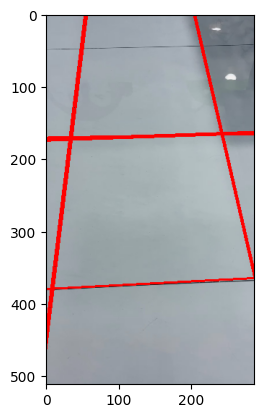

In [147]:
plt.imshow(img_c)
plt.show()

We can observe that there are multiple lines duplicate or stack up each other. Thus, we are moving on the next stage, **filtering lines** *(or merge and averaging)* process.

### 3.0 Filter

#### Cleaning-Up `cv2.HoughLines` Output  

After `cv2.HoughLines` we can get **many near-duplicate `(ρ, θ)` pairs** for the *same* physical edge.  
The merge-and-average pass below shrinks that noisy list down to **one stable line per cluster**.

---

##### Purpose  

* **Fewer lines** – one per real edge, not five copies.  
* **Stable parameters** – averaged ρ/θ values shake out pixel-level noise.  
* **Ready for math** – clean intersections, easier slope calculations, nicer overlays.

---

##### Key Ideas in the Code  

| Step | Principle | Purpose |
|------|--------------|--------------|
| **Pick a seed** | Start from a line not yet “visited”. | Avoid double-processing. |
| **Compare to others** | Compute <br> `angleD = abs(θᵢ – θⱼ)` </br> `pD = abs(ρᵢ – ρⱼ)` | Nearby angle **and** distance ⇒ same edge. |
| **Thresholds** | `angleBias = 0.3 rad` (≈17°) <br>`p_bias = 20 px` | Tune to image scale & tolerance. |
| **Cluster & average** | Collect matches, then `np.mean(...)` → one `(ρ, θ)`. | Yields a robust representative line. |
| **Keep singletons** | If a line finds no neighbours, keep it. | Saves real isolated edges. |
---

#### Code Without Debug Logging

```python
angleBias = 0.3       # ≈17°
p_bias    = 20        # pixels
visited   = []
lines_filtered = []

for i in range(len(lines)):
    if list(lines[i][0]) in visited:
        continue

    cluster, clustered = [], False
    for j in range(i, len(lines)):
        angleD = abs(lines[i][0][1] - lines[j][0][1])
        pD     = abs(lines[i][0][0] - lines[j][0][0])

        if angleD < angleBias and pD < p_bias:
            cluster.extend([lines[j]])
            visited.append(list(lines[j][0]))
            clustered = True

    # keep average   or   raw line
    out = np.mean(cluster, axis=0) if clustered else lines[i]
    lines_filtered.append(out)


In [181]:
# Uncomment commented print for more detailed logging
lines_filtered_imgs=[]
for pos,lines in enumerate(lines_imgs):
    
    print(f"\n---------------Img {pos+1}---------------\n")    
    
    lines_filtered=[]
    visited=[]
    angleBias=0.3
    p_bias=20

    for i in range(len(lines)-1):
        lines_=[]
        check=False
        
        if list(lines[i][0]) in visited: continue

        for j in range(i,len(lines)):
            c=False

            angleD=np.abs(lines[i][0][1]-lines[j][0][1])
            pD=np.abs(lines[i][0][0]-lines[j][0][0])

            # print(f'\nFirst line: {lines[i]}; Second line: {lines[j]}; Difference:\nAngle: {angleD}\nLine: {pD}\nCond:',end=' ')

            if angleD<angleBias and pD<p_bias:
            
                # print('Take')
            
                lines_.append(lines[i])
                lines_.append(lines[j])
                visited.append(list(lines[i][0]))
                visited.append(list(lines[j][0]))

                check=True
                c=True
                
            if not c:
                # print('Pass')
                pass

        
        print('---Take and Average Process---')
        
        if not check:
            print(f'Not average; Value: {lines[i]}')
            
            lines_filtered.append(lines[i])
            visited.append(list(lines[i][0]))
            
            print(f'Visited: {visited}')
            print('-----------------------------')
        
        else:
            print(f'Average; value need to average {lines_}')
            print(f'Values: {np.mean(lines_,axis=0)}')
            
            lines_filtered.append(np.mean(lines_,axis=0))
            
            print(f'Visited: {visited}')
            print('-----------------------------')
    print(f'Result: {lines_filtered}')
    lines_filtered_imgs.append(lines_filtered)


---------------Img 1---------------

---Take and Average Process---
Average; value need to average [array([[943.       ,   1.5707964]], dtype=float32), array([[943.       ,   1.5707964]], dtype=float32), array([[943.       ,   1.5707964]], dtype=float32), array([[940.       ,   1.5707964]], dtype=float32), array([[943.       ,   1.5707964]], dtype=float32), array([[945.      ,   1.553343]], dtype=float32), array([[943.       ,   1.5707964]], dtype=float32), array([[947.      ,   1.553343]], dtype=float32)]
Values: [[943.375      1.566433]]
Visited: [[943.0, 1.5707964], [943.0, 1.5707964], [943.0, 1.5707964], [940.0, 1.5707964], [943.0, 1.5707964], [945.0, 1.553343], [943.0, 1.5707964], [947.0, 1.553343]]
-----------------------------
---Take and Average Process---
Average; value need to average [array([[-384.       ,    2.7750735]], dtype=float32), array([[-384.       ,    2.7750735]], dtype=float32), array([[-384.       ,    2.7750735]], dtype=float32), array([[-381.       ,    2.775

Drawing filtered lines and saved the result into `path`

In [182]:
countFails=0
path='results/imgs/Temp2'
colors_imgs=[]

for pos,lines_filtered in enumerate(lines_filtered_imgs):

    img=imgs[pos]

    if lines_filtered is not None:

        colors=[(random.randint(10,255),random.randint(20,255),random.randint(30,255)) for i in range(len(lines_filtered))]
        img_c=img.copy()

        for i in range(len(lines_filtered)):
            rho=lines_filtered[i][0][0]
            theta=lines_filtered[i][0][1]

            x0=rho*np.cos(theta)
            y0=rho*np.sin(theta)

            a=np.cos(theta)
            b=np.sin(theta)

            x1=int(x0+1000*(-b))
            y1=int(y0+1000*(a))
            x2=int(x0-1000*(-b))
            y2=int(y0-1000*(a))
            cv2.line(img_c,(x1,y1),(x2,y2),colors[i],5)

        colors_imgs.append(colors)
        print(f'Saved result of image {pos+1} at {path}/{pos+1}.jpg')
        cv2.imwrite(f'{path}/{pos+1}.jpg',img_c)

if countFails: print(f'There are {countFails} images failed!')
else: print('All passed!')

Saved result of image 1 at results/imgs/Temp2/1.jpg
Saved result of image 2 at results/imgs/Temp2/2.jpg
Saved result of image 3 at results/imgs/Temp2/3.jpg
Saved result of image 4 at results/imgs/Temp2/4.jpg
Saved result of image 5 at results/imgs/Temp2/5.jpg
Saved result of image 6 at results/imgs/Temp2/6.jpg
Saved result of image 7 at results/imgs/Temp2/7.jpg
All passed!


Displaying the last image output.

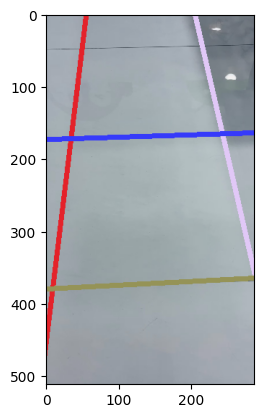

In [183]:
lines_filtered=lines_filtered_imgs[-1]
img=imgs[-1]
if lines_filtered is not None:

    colors=[(random.randint(10,255),random.randint(20,255),random.randint(30,255)) for i in range(len(lines_filtered))]
    img_c=img.copy()

    for i in range(len(lines_filtered)):
        rho=lines_filtered[i][0][0]
        theta=lines_filtered[i][0][1]

        x0=rho*np.cos(theta)
        y0=rho*np.sin(theta)

        a=np.cos(theta)
        b=np.sin(theta)

        x1=int(x0+1000*(-b))
        y1=int(y0+1000*(a))
        x2=int(x0-1000*(-b))
        y2=int(y0-1000*(a))
        cv2.line(img_c,(x1,y1),(x2,y2),colors[i],5)
    plt.imshow(img_c)

Getting the direction

Calcualte angle of the last line (Take for example)

In [151]:
taken_line=lines_filtered_imgs[taken_pos]
taken_img=imgs[taken_pos].copy()
taken_line=np.array(taken_line).reshape(len(taken_line),2)

In [152]:
taken_line

array([[ 6.6459998e+02,  1.5655602e+00],
       [ 3.5141666e+02,  8.1448697e-02],
       [-4.2810001e+02,  2.9199357e+00],
       [ 4.6629999e+02,  1.5760322e+00],
       [ 2.2500000e+02,  4.2469677e-01],
       [ 1.0036000e+03,  1.5585790e+00],
       [-4.6225000e+02,  2.6529005e+00],
       [ 3.3500000e+02,  1.5838861e+00],
       [ 2.4600000e+02,  3.7233689e-01],
       [ 8.0700000e+02,  4.5378560e-01]], dtype=float32)

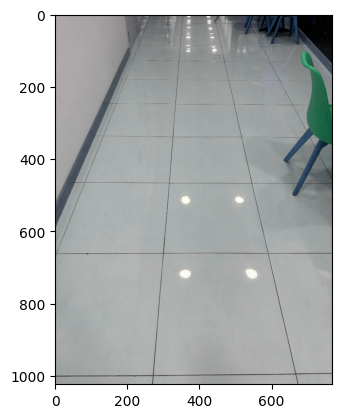

In [153]:
plt.imshow(taken_img)

p: 664.5999755859375; theta: 1.565560221672058


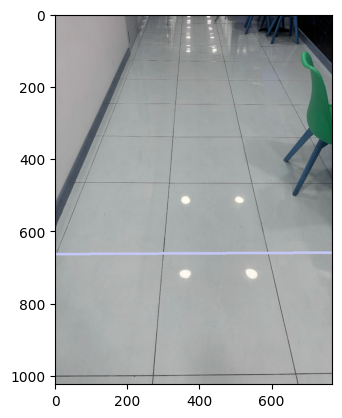

p: 351.4166564941406; theta: 0.08144869655370712


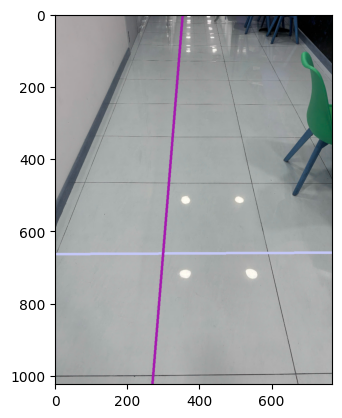

p: -428.1000061035156; theta: 2.919935703277588


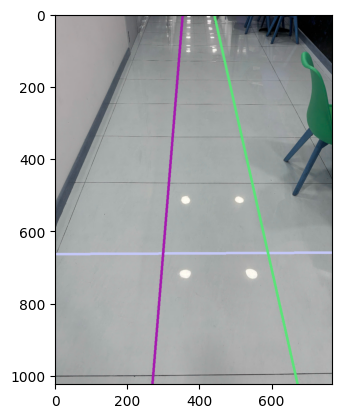

p: 466.29998779296875; theta: 1.5760321617126465


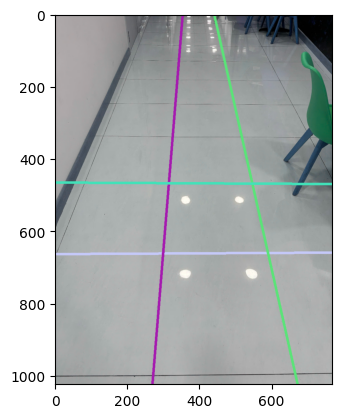

p: 225.0; theta: 0.42469677329063416


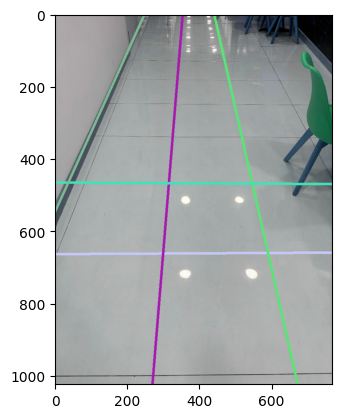

p: 1003.5999755859375; theta: 1.5585789680480957


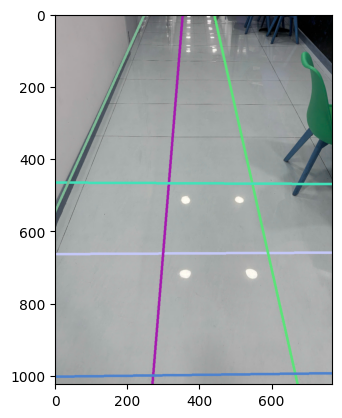

p: -462.25; theta: 2.652900457382202


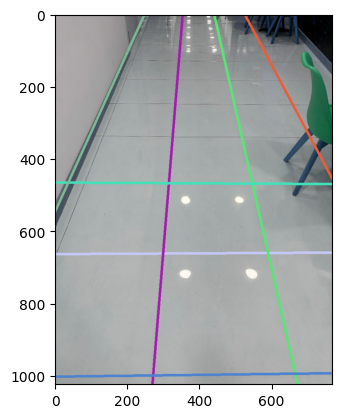

p: 335.0; theta: 1.5838861465454102


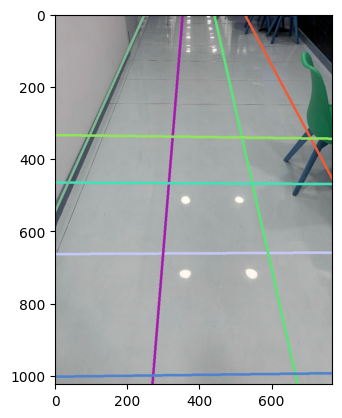

p: 246.0; theta: 0.37233689427375793


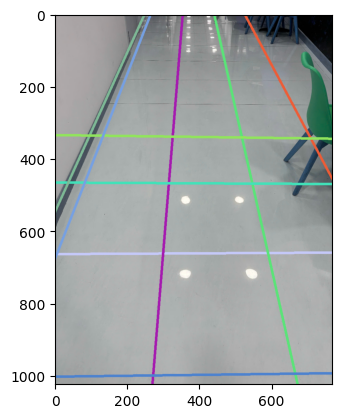

p: 807.0; theta: 0.45378559827804565


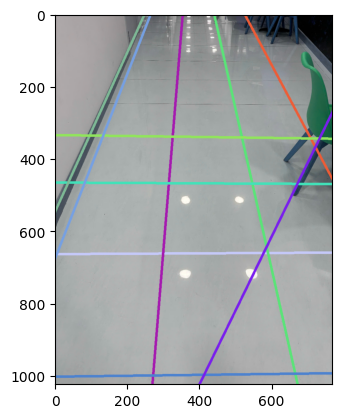

In [154]:
draw(taken_img,taken_line.reshape(len(taken_line),1,2))

Convert camera angle to bird view angle

In [155]:
H,W=taken_img.shape[:-1]
thetas=taken_line[:,1]
rhos=taken_line[:,0]
lines_index=np.array(range(len(rhos)))

In [156]:
# Calculate the intercepts of x_axis and y_axis of each lines to determnine delta_x and delta_y for arctan2 formula
# x_intercept=p/cos(theta) ; y_intercept=p/sin(theta)
# 2 coordinates from x_axis and y_axis intercepts; x_axis_intercept => (x_intercept,0) ; y_axis_intercept => (0,y_intercept)
x_intercepts=rhos/np.cos(thetas)

x_intercepts_f=x_intercepts[np.logical_and(x_intercepts<=W, x_intercepts>=0)]
rhos_f=rhos[np.logical_and(x_intercepts<=W, x_intercepts>=0)]
lines_index_f=lines_index[np.logical_and(x_intercepts<=W, x_intercepts>=0)]

#Filtered lines with the same direction (positive rho or negative rho); 
# with positive rho for left and negative for right, respectively.
rhos_f_l=rhos_f[rhos_f>0]
rhos_f_r=rhos_f[rhos_f<0]

left_lines=lines_index_f[rhos_f>0]
right_lines=lines_index_f[rhos_f<0]

#Left lines calculate delta_y
delta_y_l=x_intercepts_f[rhos_f>0]/np.tan(thetas[left_lines])

#Right lines calculate delta_y
delta_y_r=(W-x_intercepts_f[rhos_f<0])/np.tan(2*np.pi-thetas[right_lines])

In [157]:
# Calculate startpoints and endpoints
#
#
end_points_l=[]
start_points_l=[(x_,0) for x_ in x_intercepts_f[rhos_f>0]]

end_points_r=[]
start_points_r=[(x_,0) for x_ in x_intercepts_f[rhos_f<0]]


for i,delta_y in enumerate(delta_y_l):
    if delta_y<=H:
        end_points_l.append((0,rhos_f_l[i]/np.sin(thetas[left_lines[i]])))
        continue
    end_points_l.append((rhos_f_l[i]-H*np.sin(thetas[left_lines[i]])/np.cos(thetas[left_lines[i]]),H))

for i,delta_y in enumerate(delta_y_r):
    if delta_y<=H:
        end_points_r.append((W,(rhos_f_r[i]-W*np.cos(thetas[right_lines[i]]))/np.sin(thetas[right_lines[i]])))
        continue
    end_points_r.append(((rhos_f_r[i]-H*np.sin(thetas[right_lines[i]]))/np.cos(thetas[right_lines[i]]),H))


In [158]:
end_points_l

[(267.8282740919324, 1024), (0, 546.0575), (0, 676.2084)]

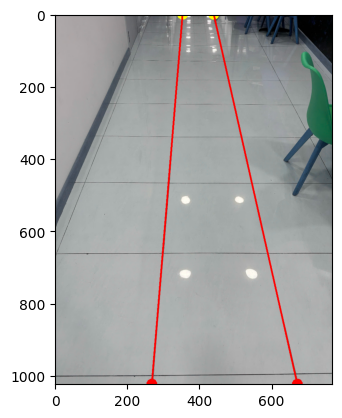

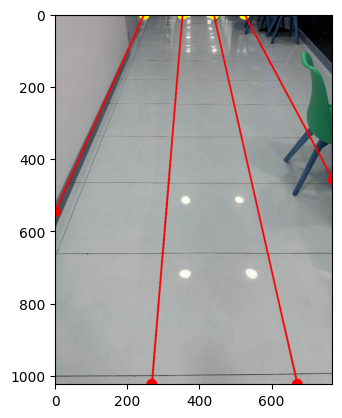

In [159]:
img_c=taken_img.copy()
for i in range(len(start_points_l)):
    try:
        cv2.circle(img_c,(int(end_points_l[i][0]),int(end_points_l[i][1])),5,(255,0,0),20)
        cv2.circle(img_c,(int(start_points_l[i][0]),int(start_points_l[i][1])),5,(255,255,0),20)
        
        cv2.circle(img_c,(int(end_points_r[i][0]),int(end_points_r[i][1])),5,(255,0,0),20)
        cv2.circle(img_c,(int(start_points_r[i][0]),int(start_points_r[i][1])),5,(255,255,0),20)

        cv2.line(img_c,(int(start_points_l[i][0]),int(start_points_l[i][1])),(int(end_points_l[i][0]),int(end_points_l[i][1])),(255,0,0),3)
        cv2.line(img_c,(int(start_points_r[i][0]),int(start_points_r[i][1])),(int(end_points_r[i][0]),int(end_points_r[i][1])),(255,0,0),3)

        plt.imshow(img_c)
        plt.show()
    except: continue

In [160]:
# Taking delta x from startpoint, and delta y from delta_y_l and delta_y_r
# # With all the delta from right lines to left lines. 
delta_x_all=np.array(list(start_points_r)+list(start_points_l))[:,0]
delta_y_all=np.array(list(delta_y_r)+list(delta_y_l))

In [161]:
# actual_angle_r=np.negative(np.arctan2(delta_y_r,np.array(start_points_r)[:,0])-np.pi/2) # Radian
# actual_angle_l=np.arctan2(delta_y_l,np.array(start_points_l)[:,0])-np.pi/2 # Radian

# print(f"Actual difference from central angle in degree form: {np.rad2deg(np.sum([actual_angle_l,actual_angle_r]))}")

In [162]:
# actual_angle=np.sum([actual_angle_l,actual_angle_r])+np.pi/2


In [163]:
# img_c1=img_c.copy()
# # Draw the heading line and central line
# start = (W // 2, H - 1)
# end_c = (W // 2, int(H - H*0.4))

# dx = int(H*0.4 * np.cos(actual_angle))
# dy = int(H*0.4 * np.sin(actual_angle))

# end_h = (start[0] + dx, start[1] - dy)      # minus because y down
# cv2.arrowedLine(img_c1, start, end_h, (0, 255, 255), 2, tipLength=0.15)  # yellow
# cv2.line(img_c1, start, end_c, (255, 255, 0), 3)  # cyan
# plt.imshow(img_c1)
# plt.show()

In [164]:
np.rad2deg(np.arctan2(delta_y_r,np.array(start_points_r)[:,0]))

array([73.27726742, 41.29056238])

### Take outlier lines.

In [165]:
lines_index_f

array([1, 2, 4, 6, 8])

In [166]:
left_lines

array([1, 4, 8])

In [167]:
end_points_r

[(669.6048752003528, 1024), (768, 459.78018964438945)]

In [168]:
end_points_l

[(267.8282740919324, 1024), (0, 546.0575), (0, 676.2084)]

In [169]:
lines_index_dict=dict()
print('Creating dictionary table for storing start, end points of lines based on their indexes.')
for i in lines_index_f:
    if i in left_lines:
        pos=list(left_lines).index(i)
        lines_index_dict[str(i)]=(start_points_l[pos],end_points_l[pos])
        print(f'Find lines index "{i}" in position "{pos}" of left_lines. Values storing -> {i}: {(start_points_l[pos],end_points_l[pos])}')
    else:
        pos=list(right_lines).index(i)
        lines_index_dict[str(i)]=(start_points_r[pos],end_points_r[pos])
        print(f'Find lines index "{i}" in position "{pos}" of right_lines. Values storing -> {i}: {(start_points_r[pos],end_points_r[pos])}')
print(f'Dictionary: {lines_index_dict}')

Creating dictionary table for storing start, end points of lines based on their indexes.
Find lines index "1" in position "0" of left_lines. Values storing -> 1: ((352.5855, 0), (267.8282740919324, 1024))
Find lines index "2" in position "0" of right_lines. Values storing -> 2: ((438.83636, 0), (669.6048752003528, 1024))
Find lines index "4" in position "1" of left_lines. Values storing -> 4: ((246.93697, 0), (0, 546.0575))
Find lines index "6" in position "1" of right_lines. Values storing -> 6: ((523.5305, 0), (768, 459.78018964438945))
Find lines index "8" in position "2" of left_lines. Values storing -> 8: ((264.09592, 0), (0, 676.2084))
Dictionary: {'1': ((352.5855, 0), (267.8282740919324, 1024)), '2': ((438.83636, 0), (669.6048752003528, 1024)), '4': ((246.93697, 0), (0, 546.0575)), '6': ((523.5305, 0), (768, 459.78018964438945)), '8': ((264.09592, 0), (0, 676.2084))}


In [170]:
left_pt_outlier=min(end_points_l, key=lambda x: x[0])
right_pt_outlier=max(end_points_r, key=lambda x: x[0])

In [171]:
left_outlier_index=left_lines[end_points_l.index(left_pt_outlier)]
right_outlier_index=right_lines[end_points_r.index(right_pt_outlier)]

### Using matrix multiplication to calculate the intercept of outlier lines from each sides

In [172]:
def line_intersection(rho1, theta1, rho2, theta2, eps=1e-9):
    """
    Return (x, y) where the two Hough-space lines intersect.
    Returns None if the lines are (nearly) parallel.
    Angles in radians.
    """
    
    denom = np.sin(theta2 - theta1)         # = Δ above
    if abs(denom) < eps:
        return None  # parallel
    x = (rho1 * np.sin(theta2)-rho2 * np.sin(theta1)) / denom
    y = (rho2 * np.cos(theta1)-rho1 * np.cos(theta2)) / denom
    return x, y

In [173]:
rho1, theta1, rho2, theta2=rhos[left_outlier_index],thetas[left_outlier_index],rhos[right_outlier_index],thetas[right_outlier_index]

In [174]:
rho1, theta1, rho2, theta2

(225.0, 0.42469677, -462.25, 2.6529005)

In [175]:
x_intercept_outlier,y_intercept_outlier=line_intersection(rho1, theta1, rho2, theta2)

In [176]:
x_intercept_outlier,y_intercept_outlier

(374.06076, -281.1118)

Difference between midpoint of img with outlier lines.

In [177]:
# Adding supplementary and accute angle conds

if x_intercept_outlier<taken_img.shape[:2][1]/2:
    actual_angle_v2=abs(math.atan2((-taken_img.shape[:2][0]),(x_intercept_outlier-taken_img.shape[:2][1]/2)))
else:
    actual_angle_v2=abs(math.atan2((taken_img.shape[:2][0]),(taken_img.shape[:2][1]/2-x_intercept_outlier)))

In [178]:
math.degrees(actual_angle_v2)

90.55611190644146

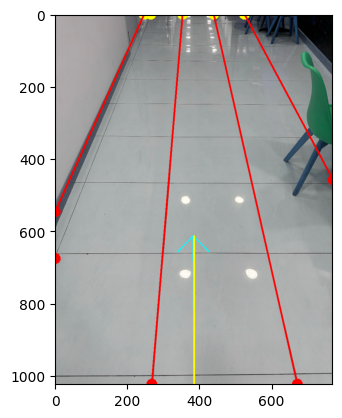

In [179]:
img_c1=img_c.copy()
# Draw the heading line and central line
start = (W // 2, H - 1)
end_c = (W // 2, int(H - H*0.4))

dx = int(H*0.4 * np.cos(actual_angle_v2))
dy = int(H*0.4 * np.sin(actual_angle_v2))

end_h = (start[0] + dx, start[1] - dy)      # minus because y down
cv2.arrowedLine(img_c1, start, end_h, (0, 255, 255), 2, tipLength=0.15)  # yellow
cv2.line(img_c1, start, end_c, (255, 255, 0), 3)  # cyan
plt.imshow(img_c1)
plt.show()